In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import os
from scipy.stats import zscore
import matplotlib.pyplot as plt

print(os.getcwd())

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the dataset
data = pd.read_csv('../data/processed_data/clustered_data.csv')

/Users/shakirmshaker/Library/Mobile Documents/com~apple~CloudDocs/Skole/DTU/ComputationalTools/Project/notebooks


In [11]:
data.head()

,props_pageProps_address_buildings_0_bathroomCondition,props_pageProps_address_buildings_0_buildingName,props_pageProps_address_buildings_0_externalWallMaterial,props_pageProps_address_buildings_0_heatingInstallation,props_pageProps_address_buildings_0_housingArea,props_pageProps_address_buildings_0_kitchenCondition,props_pageProps_address_buildings_0_numberOfFloors,props_pageProps_address_buildings_0_numberOfToilets,props_pageProps_address_buildings_0_roofingMaterial,props_pageProps_address_buildings_0_toiletCondition,props_pageProps_address_buildings_0_yearBuilt,props_pageProps_address_municipality_name,props_pageProps_address_coordinates_lat,props_pageProps_address_coordinates_lon,props_pageProps_address_events_0_at,props_pageProps_address_events_0_label,props_pageProps_dataLayer_virtualPagePath,lastPrice,sqm_price,years_from_today,years_from_today_weighted,cluster,color
0,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Letbetonsten,Varmepumpe,195.000,Eget køkken med afløb,1.000,3.000,Tagpap med lille hældning,Vandskyllende toilet i enheden,2017.000,Helsingør,56.015,12.597,2017-07-31 00:00:00+00:00,Fri handel,/adresse/kirsebaerbakken-1-3070-snekkersten-02...,5300000.000,27179.487,6,36,1,#ff7f0e
1,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,120.000,Eget køkken med afløb,1.000,1.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1970.000,Helsingør,55.993,12.491,2011-05-17 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-2c-3490-kvistgaard-...,1900000.000,15833.333,12,144,0,#1f77b4
2,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Varmepumpe,162.000,Eget køkken med afløb,1.000,2.000,Betontagsten,Vandskyllende toilet i enheden,1932.000,Helsingør,55.993,12.491,2002-05-28 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-5-3490-kvistgaard-0...,1848944.000,11413.235,21,441,2,#2ca02c
3,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Varmepumpe,98.000,Eget køkken med afløb,1.000,1.000,Tagpap med stor hældning,Vandskyllende toilet i enheden,1942.000,Helsingør,55.993,12.491,2023-08-22 00:00:00+00:00,Fri handel,/adresse/axel-moellers-vej-6-3490-kvistgaard-0...,2450000.000,25000.000,0,0,0,#1f77b4
4,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Træ,Centralvarme med én fyringsenhed,200.000,Eget køkken med afløb,1.000,2.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1967.000,Helsingør,56.073,12.538,2022-01-26 00:00:00+00:00,Fri handel,/adresse/alexander-svedstrups-vej-2-3140-aalsg...,5000000.000,25000.000,1,1,1,#ff7f0e


In [12]:
# Function to remove outliers based on Interquartile Range (IQR)
def remove_outliers_iqr(group_df):
    Q1 = group_df['sqm_price'].quantile(0.25)
    Q3 = group_df['sqm_price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group_df[(group_df['sqm_price'] >= lower_bound) & (group_df['sqm_price'] <= upper_bound)]

# Group by 'props_pageProps_address_municipality_name' and apply the remove_outliers function
data = data.groupby('props_pageProps_address_municipality_name').apply(remove_outliers_iqr).reset_index(drop=True)

In [13]:
municcipalities = data['props_pageProps_address_municipality_name'].unique()

In [ ]:
rmse_scores = {}

for municipality in municcipalities:

    filtered_data = data[data['props_pageProps_address_municipality_name'] == municipality]

    target = 'sqm_price'

    # Preparing the data for the model
    X = filtered_data.drop([target, 'lastPrice', 'props_pageProps_address_events_0_at', 'props_pageProps_address_events_0_label',
                'props_pageProps_dataLayer_virtualPagePath', 'years_from_today',
                'props_pageProps_address_coordinates_lat', 'props_pageProps_address_coordinates_lon', 'color', 'cluster'], axis=1)

    y = filtered_data[target]

    # Encoding categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category', 'string']).columns
    numerical_cols = X.select_dtypes(include=[np.number]).columns

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[categorical_cols])

    # Standardizing numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[numerical_cols])

    # Combining encoded categorical and scaled numerical features
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)
    X_combined = pd.concat([X_scaled_df, X_encoded_df], axis=1)

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # Training a RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Predicting and evaluating the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    rmse_scores[municipality] = rmse

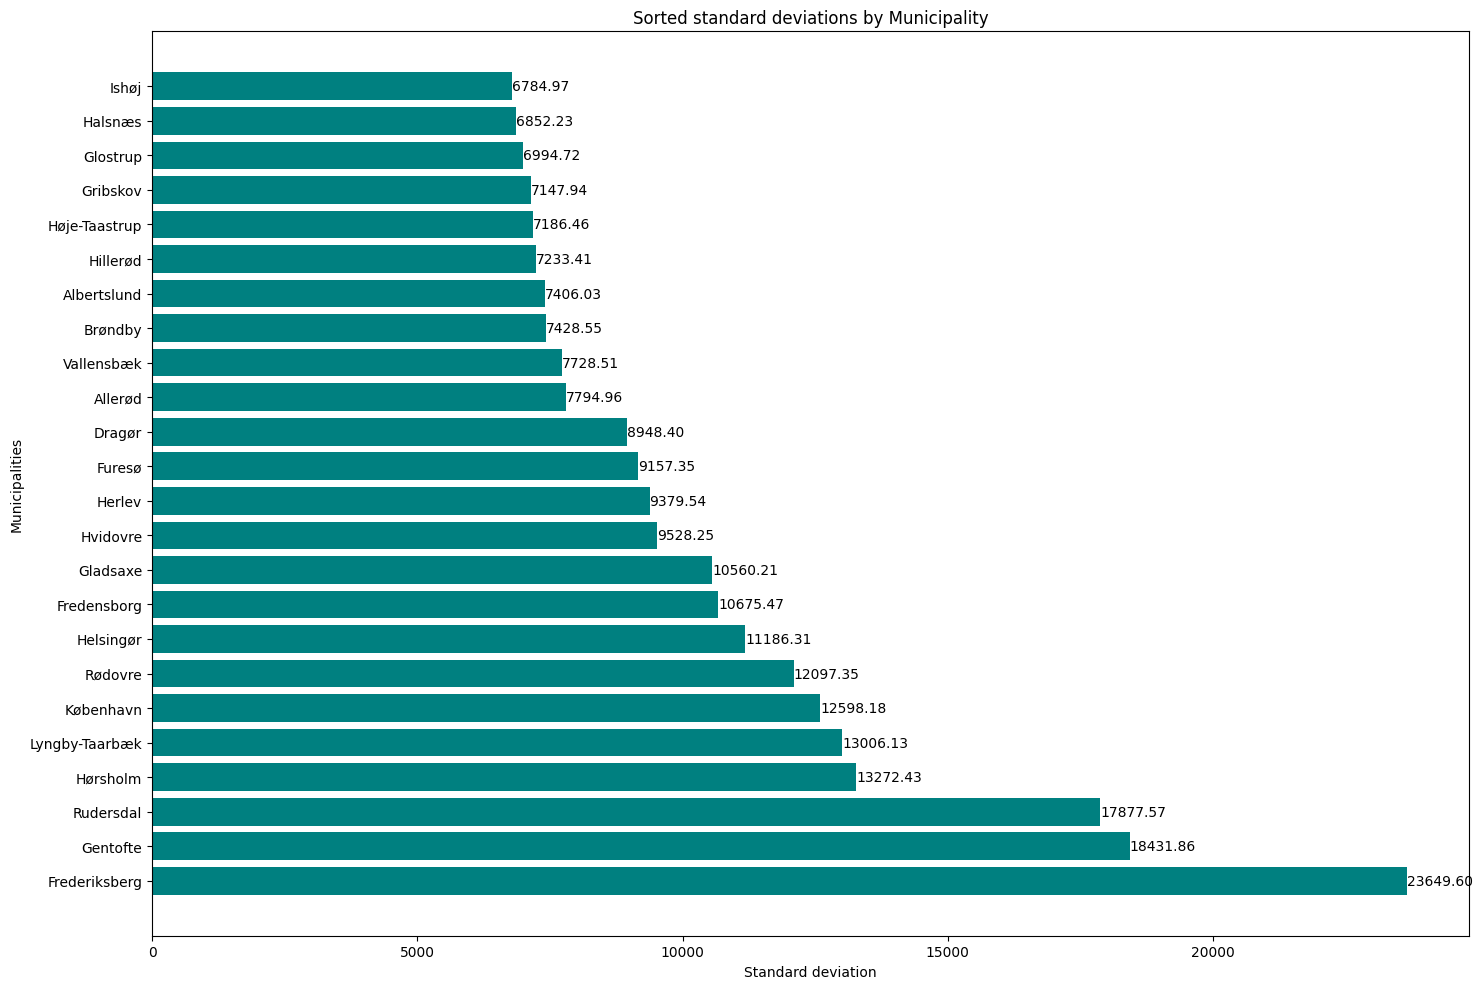

In [25]:
initial_stds = dict(data.groupby('props_pageProps_address_municipality_name')['sqm_price'].std())

# Sorting the standard deviations in reverse order for better visualization in a bar chart
initial_stds_sorted = dict(sorted(initial_stds.items(), key=lambda item: item[1], reverse=True))

# Creating the sorted bar chart with the value of each bar inside the bar
plt.figure(figsize=(15, 10))
bars = plt.barh(list(initial_stds_sorted.keys()), list(initial_stds_sorted.values()), color='teal')
plt.xlabel('Standard deviation')
#plt.xlim(0, 14000)  # Set a limit for the x-axis
plt.ylabel('Municipalities')
plt.title('Sorted standard deviations by Municipality')

# Adding the value of each bar inside the bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left')

plt.tight_layout()

# Show the plot
plt.show()

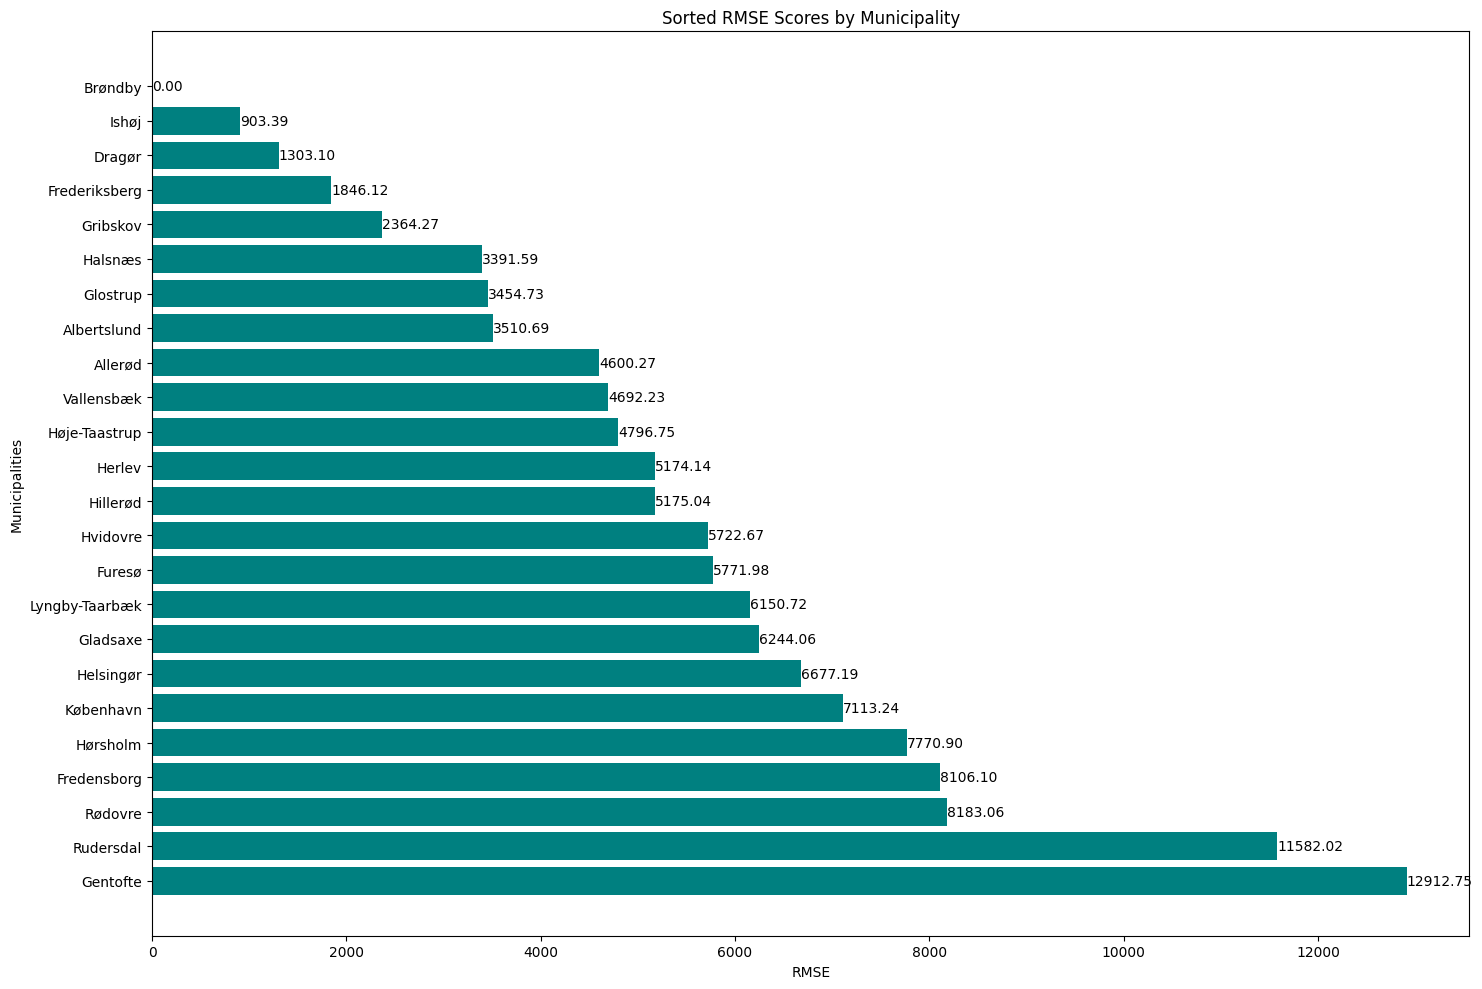

In [18]:
sorted_rmse = dict(sorted(rmse_scores.items(), key=lambda item: item[1], reverse=True))

# Creating the sorted bar chart with the value of each bar inside the bar
plt.figure(figsize=(15, 10))
bars = plt.barh(list(sorted_rmse.keys()), list(sorted_rmse.values()), color='teal')
plt.xlabel('RMSE')
plt.ylabel('Municipalities')
plt.title('Sorted RMSE Scores by Municipality')

# Adding the value of each bar inside the bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left')

plt.tight_layout()

# Show the plot
plt.show()